In [151]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import random
from collections import Counter



In [442]:
# activate GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [443]:
diabetes = pd.read_csv('diabetes.csv')
diabetes

,-1,-0.294118,0.487437,0.180328,-0.292929,-1.1,0.00149028,-0.53117,-0.0333333
0,1,-0.882353,-0.145729,0.081967,-0.414141,-1.000000,-0.207153,-0.766866,-0.666667
1,-1,-0.058824,0.839196,0.049180,-1.000000,-1.000000,-0.305514,-0.492741,-0.633333
2,1,-0.882353,-0.105528,0.081967,-0.535354,-0.777778,-0.162444,-0.923997,-1.000000
3,-1,-1.000000,0.376884,-0.344262,-0.292929,-0.602837,0.284650,0.887276,-0.600000
4,1,-0.411765,0.165829,0.213115,-1.000000,-1.000000,-0.236960,-0.894962,-0.700000
...,...,...,...,...,...,...,...,...,...
762,1,0.176471,0.015075,0.245902,-0.030303,-0.574468,-0.019374,-0.920581,0.400000
763,1,-0.764706,0.226131,0.147541,-0.454545,-1.000000,0.096870,-0.776260,-0.800000
764,1,-0.411765,0.216080,0.180328,-0.535354,-0.735225,-0.219076,-0.857387,-0.700000
765,-1,-0.882353,0.266332,-0.016393,-1.000000,-1.000000,-0.102832,-0.768574,-0.133333


In [444]:
# Data processing
diabetes.isna().any()

-1            False
-0.294118     False
0.487437      False
0.180328      False
-0.292929     False
-1.1          False
0.00149028    False
-0.53117      False
-0.0333333     True
dtype: bool

In [445]:
diabetes.dropna(inplace=True)

In [446]:
X = diabetes.iloc[:, 1:].values
y = diabetes.iloc[:, 0].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the value
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)

X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.FloatTensor(y_test).to(device)



train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)

test_data = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(dataset=test_data, batch_size=64, shuffle=False)

criterion = nn.BCELoss().to(device)

In [476]:
#Original MLP model
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 50)
        self.fc2 = nn.Linear(50, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return self.sigmoid(x)

#MLP with dropout
class MLPWithDropout(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.5): 
        super(MLPWithDropout, self).__init__()
        self.fc1 = nn.Linear(input_dim, 50)
        self.dropout = nn.Dropout(dropout_rate) 
        self.fc2 = nn.Linear(50, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x) 
        x = self.fc2(x)
        return self.sigmoid(x)

#Function to draw the lost curve
def Loss_curve(model, criterion, optimizer, train_loader, X_test_tensor, y_test_tensor, num_epochs):
    
    losses = [] 

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0 
        
        for i, (inputs, labels) in enumerate(train_loader):
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()

        average_loss = epoch_loss / len(train_loader) 
        losses.append(average_loss)
        
    with torch.no_grad():
        test_outputs = model(X_test_tensor).squeeze()
        test_outputs = (test_outputs > 0.5).float()
        accuracy = (test_outputs == y_test_tensor).float().mean()
    
    print(f"Accuracy: {accuracy:.4f}")

    return losses

#Trainning function
def train_model_and_get_accuracy(model, criterion, optimizer, train_loader, X_test_tensor, y_test_tensor, num_epochs):
    
    for epoch in range(num_epochs):
        model.train()
        
        for i, (inputs, labels) in enumerate(train_loader):
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    with torch.no_grad():
        test_outputs = model(X_test_tensor).squeeze()
        test_outputs = (test_outputs > 0.5).float()
        accuracy = (test_outputs == y_test_tensor).float().mean()
    
    return accuracy.item()

#Function to find the best batch size
def find_best_batch_size(batch_sizes, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, Model, criterion,optimizer,epoch):
    best_acc = 0.0
    best_batch_size = None
    for bs in batch_sizes:
        train_data = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(dataset=train_data, batch_size=bs, shuffle=True)

        test_data = TensorDataset(X_test_tensor, y_test_tensor)
        test_loader = DataLoader(dataset=test_data, batch_size=bs, shuffle=False)
        model = Model(X_train.shape[1]).to(device)
        
        optimizer = optimizer
        accuracy = train_model_and_get_accuracy(model, criterion, optimizer, train_loader, X_test_tensor, y_test_tensor, epoch)
        if accuracy > best_acc:
            best_acc = accuracy
            best_batch_size = bs

    return best_batch_size, best_acc  

Accuracy: 0.7171


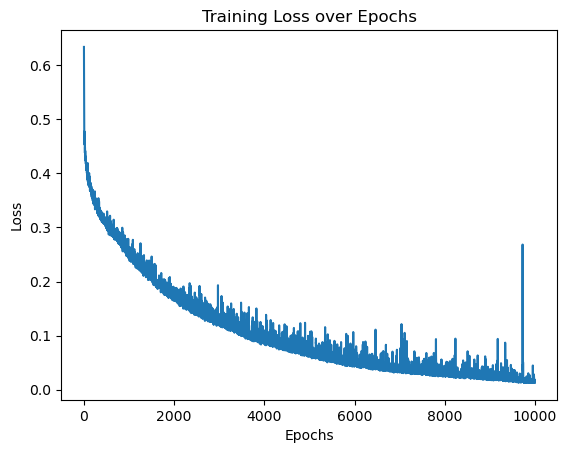

In [448]:
#Estimate the epoch range of MLP
model = MLP(X_train_tensor.shape[1]).to(device)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
epoch_losses = Loss_curve(model, criterion, optimizer, train_loader, X_test_tensor, y_test_tensor, 10000)


plt.plot(epoch_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

Accuracy: 0.7171


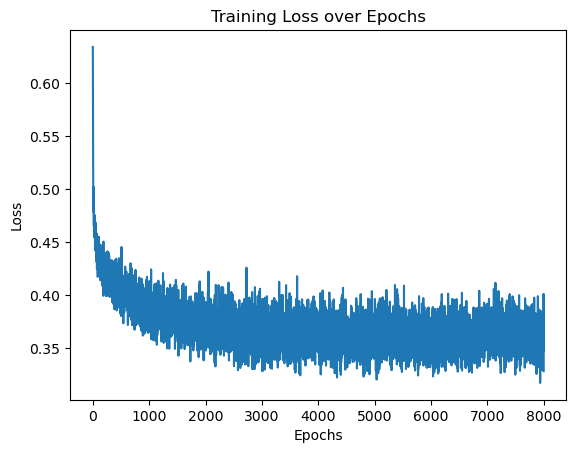

In [449]:
#Estimate the epoch range of MLP with dropout 
model = MLPWithDropout(X_train.shape[1]).to(device)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
epoch_losses = Loss_curve(model, criterion, optimizer, train_loader, X_test_tensor, y_test_tensor, 8000)


plt.plot(epoch_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

In [469]:
#Use random search to find the best lr and epoch for MLP
learning_rates = [0.1, 0.01, 0.005]
epochs_list1 = [20,50,100,500]

#Epoch_llist2 only for lr = 0.005 to save resource
epochs_list2 = [8000]
num_iterations = 100
best_acc = float('-inf')

for _ in range(num_iterations):

    lr = random.choice(learning_rates)
    if lr != 0.005:
        epochs = random.choice(epochs_list1)
    else:
        epochs = random.choice(epochs_list2)
    
    model = MLP(X_train.shape[1]).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    accuracy = train_model_and_get_accuracy(model, criterion, optimizer, train_loader, X_test_tensor, y_test_tensor, epochs)

    if accuracy > best_acc:
        best_acc = accuracy
        best_lr = lr
        best_epochs = epochs

print(f"Best LR: {best_lr}, Best Epochs: {best_epochs}, Best Accuracy: {best_acc:.4f}")


Best LR: 0.01, Best Epochs: 20, Best Accuracy: 0.7895


In [454]:
#Use random search to find the best lr and epoch for MLPWihDropout
learning_rates = [0.1, 0.01, 0.005]
epochs_list1 = [20,50,100,500,1000]
epochs_list2 = [1000, 3000]
num_iterations = 100
best_acc = float('-inf')

for _ in range(num_iterations):
    
    lr = random.choice(learning_rates)
    if lr != 0.005:
        epochs = random.choice(epochs_list1)
    else:
        epochs = random.choice(epochs_list2)
    
    model = MLPWithDropout(X_train.shape[1]).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    accuracy = train_model_and_get_accuracy(model, criterion, optimizer, train_loader, X_test_tensor, y_test_tensor, epochs)    

    if accuracy > best_acc:
        best_acc = accuracy
        best_lr = lr
        best_epochs = epochs

print(f"Best LR: {best_lr}, Best Epochs: {best_epochs}, Best Accuracy: {best_acc:.4f}")

Best LR: 0.01, Best Epochs: 20, Best Accuracy: 0.7829


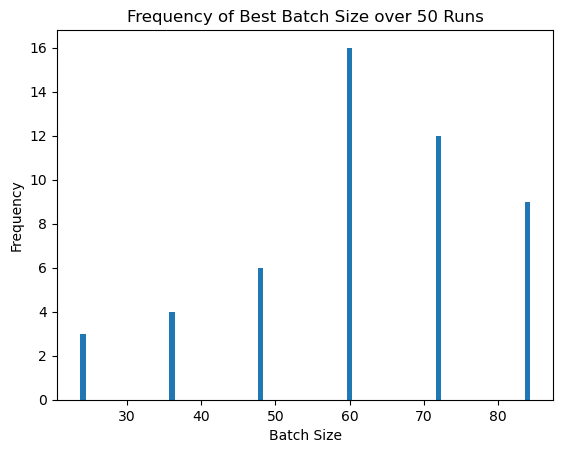

In [463]:
#Search for the best batch size for MLP
lr = 0.01
epoch = 20
batch_sizes = [24,36,48,60,72,84]
best_batch_sizes = []
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
for _ in range(50):
    best_bs, _ = find_best_batch_size(batch_sizes, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, MLP, criterion,optimizer,epoch)
    best_batch_sizes.append(best_bs)

batch_size_freq = Counter(best_batch_sizes)

plt.bar(batch_size_freq.keys(), batch_size_freq.values())
plt.xlabel("Batch Size")
plt.ylabel("Frequency")
plt.title("Frequency of Best Batch Size over 50 Runs")
plt.show()

In [468]:
#Use random search to find the best lr and epoch for MLP with SGD
learning_rates = [0.1, 0.01, 0.005]
epochs_list1 = [20,50,100,500]

#Epoch_llist2 only for lr = 0.005 to save resource
epochs_list2 = [6000, 8000]
num_iterations = 100
best_acc = float('-inf')

for _ in range(num_iterations):

    lr = random.choice(learning_rates)
    if lr != 0.005:
        epochs = random.choice(epochs_list1)
    else:
        epochs = random.choice(epochs_list2)
    
    model = MLP(X_train.shape[1]).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
    accuracy = train_model_and_get_accuracy(model, criterion, optimizer, train_loader, X_test_tensor, y_test_tensor, epochs)

    if accuracy > best_acc:
        best_acc = accuracy
        best_lr = lr
        best_epochs = epochs

print(f"Best LR: {best_lr}, Best Epochs: {best_epochs}, Best Accuracy: {best_acc:.4f}")

Best LR: 0.1, Best Epochs: 50, Best Accuracy: 0.7961


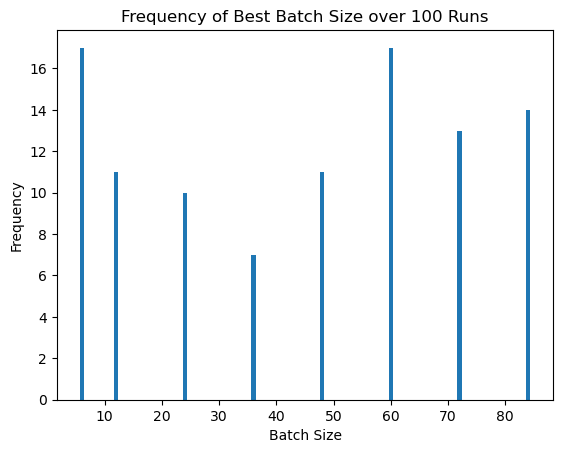

In [478]:
#Search for the best batch size for MLP with SGD
lr = 0.1
epoch = 100
batch_sizes = [6,12,24,36,48,60,72,84]
best_batch_sizes = []
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
for _ in range(100):
    best_bs, _ = find_best_batch_size(batch_sizes, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, MLP, criterion,optimizer,epoch)
    best_batch_sizes.append(best_bs)

batch_size_freq = Counter(best_batch_sizes)

plt.bar(batch_size_freq.keys(), batch_size_freq.values())
plt.xlabel("Batch Size")
plt.ylabel("Frequency")
plt.title("Frequency of Best Batch Size over 100 Runs")
plt.show()

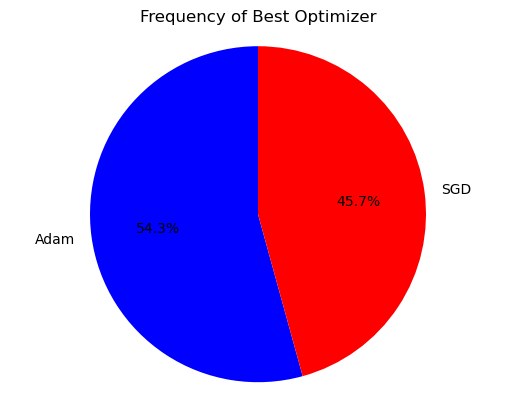

Mean Accuracy of Adam: 0.7782
Mean Accuracy of SGD: 0.7788


In [486]:
#Compare SGD and Adam at best parameters combination
accs = {"Adam": [], "SGD": []}
best_optimizer = []
for _ in range(70):
    
    model = MLP(X_train.shape[1]).to(device)
    optimizer1 = torch.optim.Adam(model.parameters(), lr=0.01)
    optimizer2 = torch.optim.SGD(model.parameters(), lr=0.1)
    
    train_loader = DataLoader(dataset=train_data, batch_size=60, shuffle=True)
    
    Adam_acc = train_model_and_get_accuracy(model, criterion, optimizer1, train_loader, X_test_tensor, y_test_tensor, 20)  
    SGD_acc = train_model_and_get_accuracy(model, criterion, optimizer2, train_loader, X_test_tensor, y_test_tensor, 50)  
    
    if Adam_acc > SGD_acc:
        best_optimizer.append("Adam")
        accs["Adam"].append(Adam_acc)
    else:
        best_optimizer.append("SGD")
        accs["SGD"].append(SGD_acc)



optimizer_counts = Counter(best_optimizer)
labels = list(optimizer_counts.keys())
sizes = list(optimizer_counts.values())
colors = ['blue', 'red'][:len(labels)]

# Plot the pie chart
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  
plt.title('Frequency of Best Optimizer')
plt.show()

# Print the mean accuracy of best optimizer
print(f"Mean Accuracy of Adam: {sum(accs['Adam']) / len(accs['Adam']) if accs['Adam'] else 0:.4f}")
print(f"Mean Accuracy of SGD: {sum(accs['SGD']) / len(accs['SGD']) if accs['SGD'] else 0:.4f}")